# **Installations Required**

In [ ]:
# Installations
!pip install adversarial-robustness-toolbox
!pip install tensorflow==2.13.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 49.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 47.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 67.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 24.2 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.12.2
    Uninstalling typing_extensions-4.12.2:
      Successfully uninstalled typing_extensions-4.12.2
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0
  Attempting uninstall: gast
  

# **Imports for dataset loading, declaring the model and the MIA attack**

In [ ]:
# Imports

# for dataset
from keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# for model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Sequential
import keras.backend as k

# for attack
import warnings
import numpy as np
import tensorflow as tf
from numpy.random import seed
from art.estimators.classification import KerasClassifier
from art.attacks.inference.model_inversion.mi_face import MIFace
import matplotlib.pyplot as plt

tf.compat.v1.disable_eager_execution()
warnings.filterwarnings('ignore')
seed(123)

# **Data Preprocessing**
*   Load MNIST Dataset
*   In federated learning, each client will have different datasets
*   Client1 - First 5 labels of MNIST
*   Client2 - Last 5 labels of MNIST
*   After loading the datasets, we have printed the shapes of dataset, and first 5 samples of the dataset for client1 and client2


11490434/11490434 [==============================] - 0s 0us/step
Trainset 1 shape: (30596, 28, 28, 1), Trainset 2 shape: (29404, 28, 28, 1)
Testset 1 shape: (5139, 28, 28, 1), Testset 2 shape: (4861, 28, 28, 1)


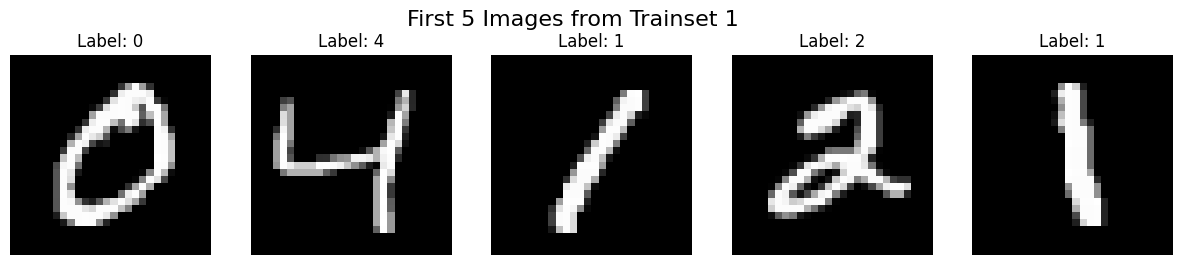

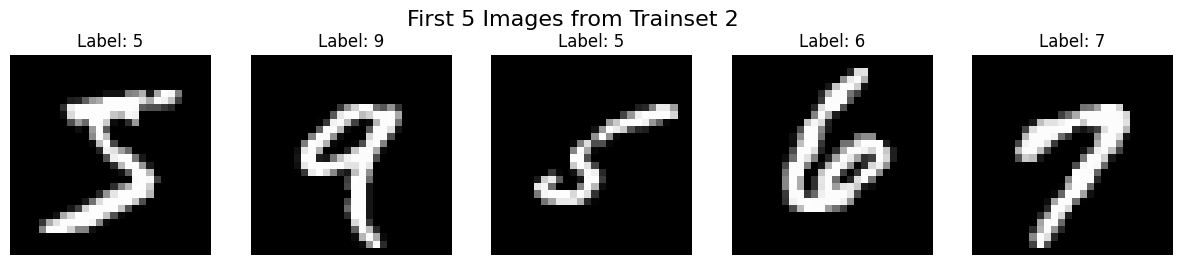

In [ ]:
# Data Preprocessing

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize and expand dimensions for channels
x_train = x_train.astype('float32') / 255.0
x_train = x_train[..., np.newaxis]  # Add channel dimension
x_test = x_test.astype('float32') / 255.0
x_test = x_test[..., np.newaxis]  # Add channel dimension

# Convert labels to categorical (one-hot encoded)
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)
# Convert one-hot encoded labels to class indices
y_train_classes = np.argmax(y_train, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Train set
# Split the MNIST training set based on the first 5 and second 5 labels
trainset1_indices = np.isin(y_train_classes, [0, 1, 2, 3, 4])  # First 5 labels
trainset2_indices = np.isin(y_train_classes, [5, 6, 7, 8, 9])  # Second 5 labels
x_train_set1 = x_train[trainset1_indices]
y_train_set1 = y_train[trainset1_indices]
x_train_set2 = x_train[trainset2_indices]
y_train_set2 = y_train[trainset2_indices]

# Test set
# Split the MNIST test set based on the first 5 and second 5 labels
testset1_indices = np.isin(y_test_classes, [0, 1, 2, 3, 4])  # First 5 labels
testset2_indices = np.isin(y_test_classes, [5, 6, 7, 8, 9])  # Second 5 labels
x_test_set1 = x_test[testset1_indices]
y_test_set1 = y_test[testset1_indices]
x_test_set2 = x_test[testset2_indices]
y_test_set2 = y_test[testset2_indices]

# Print the shape of the datasets to verify
print(f"Trainset 1 shape: {x_train_set1.shape}, Trainset 2 shape: {x_train_set2.shape}")
print(f"Testset 1 shape: {x_test_set1.shape}, Testset 2 shape: {x_test_set2.shape}")

# Function to plot images
def plot_images(images, labels, title, num_images=5):
    plt.figure(figsize=(15, 3))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title(f"Label: {np.argmax(labels[i])}")  # Display the label
        plt.axis('off')
    plt.suptitle(title, fontsize=16)
    plt.show()
# Plot the first 5 images from Trainset 1
plot_images(x_train_set1, y_train_set1, title="First 5 Images from Trainset 1")
# Plot the first 5 images from Trainset 2
plot_images(x_train_set2, y_train_set2, title="First 5 Images from Trainset 2")

# **PART1: Train the Model**
*   Declare the Model
*   For Client1 and Client2
  *   Initialize the model
  *   Train the model
  *   Test the model
*   Calculate Accuracies
  *   Client1 model testing on - client1 test set, client2 test set
  *   Client2 model testing on - client1 test set, client2 test set
*   Results
  *   As client1 is trained on first half of the labels - this could able to predict only its test set, it couldn't able to predict client2 test set.
  *   Similarly, as client2 is trained on last half of the labels - this could able to predict its only test set, it couldn't able to predict client1 test set.









In [ ]:
# Declare the model
def model(input_shape, min_val, max_val):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    classifier = KerasClassifier(clip_values=(min_val, max_val), model=model, use_logits=False)
    return classifier

# ----------------------------------- For both clients ---------------------------------------------

# Initialize the model
# Client1
client1_model = model(x_train_set1.shape[1:], 0, 1)
# Client2
client2_model = model(x_train_set2.shape[1:], 0, 1)

# Train the model
# Client1
client1_model.fit(x_train_set1, y_train_set1, nb_epochs=10, batch_size=128, verbose=0)
# Client2
client2_model.fit(x_train_set2, y_train_set2, nb_epochs=10, batch_size=128, verbose=0)

# Test the model
# Client1
predictions_set0 = client1_model.predict(x_test_set1) # Client1 test set
predicted_labels_set0 = np.argmax(predictions_set0, axis=1) # Convert probabilities to class labels
predictions_set1 = client1_model.predict(x_test_set2) # Client2 test set
predicted_labels_set1 = np.argmax(predictions_set1, axis=1)
# Client2
predictions_set2 = client2_model.predict(x_test_set1) # Client1 test set
predicted_labels_set2 = np.argmax(predictions_set2, axis=1)
predictions_set3 = client2_model.predict(x_test_set2) # Client2 test set
predicted_labels_set3 = np.argmax(predictions_set3, axis=1)

# Calculate Accuracies
# Client1
accuracy_set0 = np.mean(predicted_labels_set0 == np.argmax(y_test_set1, axis=1))
print(f"Test set accuracy Client1 model on client1 test set: {accuracy_set0:.4f}")
accuracy_set1 = np.mean(predicted_labels_set1 == np.argmax(y_test_set2, axis=1))
print(f"Test set accuracy Client1 model on client2 test set: {accuracy_set1:.4f}")
# Client2
accuracy_set2 = np.mean(predicted_labels_set2 == np.argmax(y_test_set1, axis=1))
print(f"Test set accuracy Client2 model on client1 test set: {accuracy_set2:.4f}")
accuracy_set3 = np.mean(predicted_labels_set3 == np.argmax(y_test_set2, axis=1))
print(f"Test set accuracy Client2 model on client2 test set: {accuracy_set3:.4f}")

Test set accuracy Client1 model on client1 test set: 0.9979
Test set accuracy Client1 model on client2 test set: 0.0000
Test set accuracy Client2 model on client1 test set: 0.0000
Test set accuracy Client2 model on client2 test set: 0.9944


# **PART2: Perform Model Inversion Attack**
We can observe, MIA attack is performed on client1 and client2. As, client1 is trained over first half of the labels - it could able to predict first 5 labels. And, we can observe reconstructions for 0,1,2,3,4. Coming through client2, client2 is trained over last half of the labels - it could able to predict last 5 labels. And, we can observe reconstructions for 5,6,7,8,9

Minimum over all maximum class gradient: 0.000516


Model inversion:   0%|          | 0/10 [00:00<?, ?it/s]

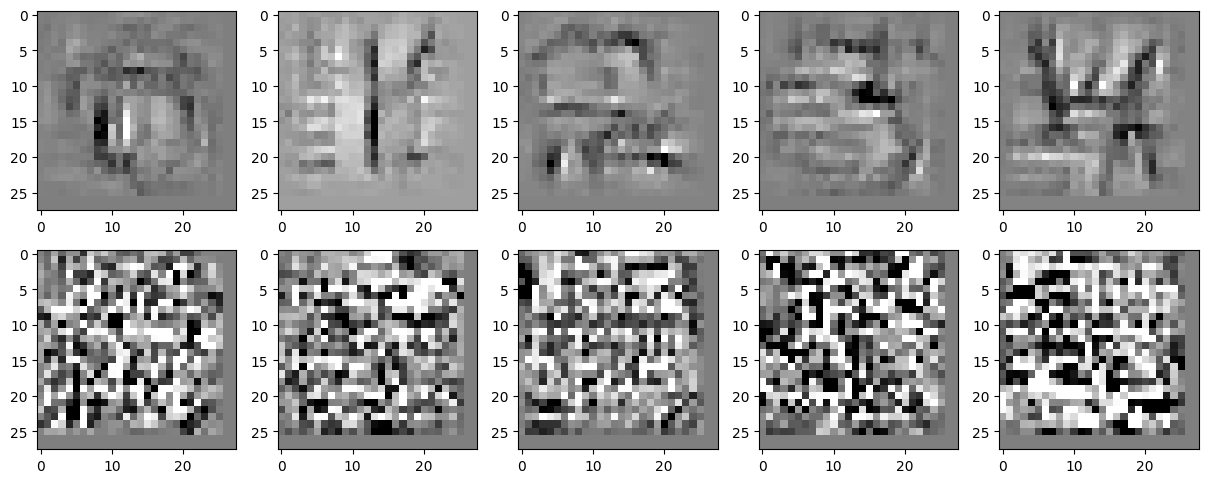

In [ ]:
# Model Inversion Attack on client1 model

# Create the attack
attack = MIFace(client1_model, max_iter=10000, threshold=1.5)
# for each 10 MNIST classes
y = np.arange(10)
# Experiment on Grey Sample
x_init_grey = np.zeros((10, 28, 28, 1)) + 0.5
# Calculate the gradient
class_gradient = client1_model.class_gradient(x_init_grey, y)
class_gradient = np.reshape(class_gradient, (10, 28*28))
class_gradient_max = np.max(class_gradient, axis=1)
print("Minimum over all maximum class gradient: %f" % (np.min(class_gradient_max)))
# Run the attack
x_infer_from_grey = attack.infer(x_init_grey, y)
# Plot the inferred images:
plt.figure(figsize=(15,15))
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.imshow( (np.reshape(x_infer_from_grey[0+i,], (28, 28))), cmap=plt.cm.gray_r)

Minimum over all maximum class gradient: 0.002282


Model inversion:   0%|          | 0/10 [00:00<?, ?it/s]

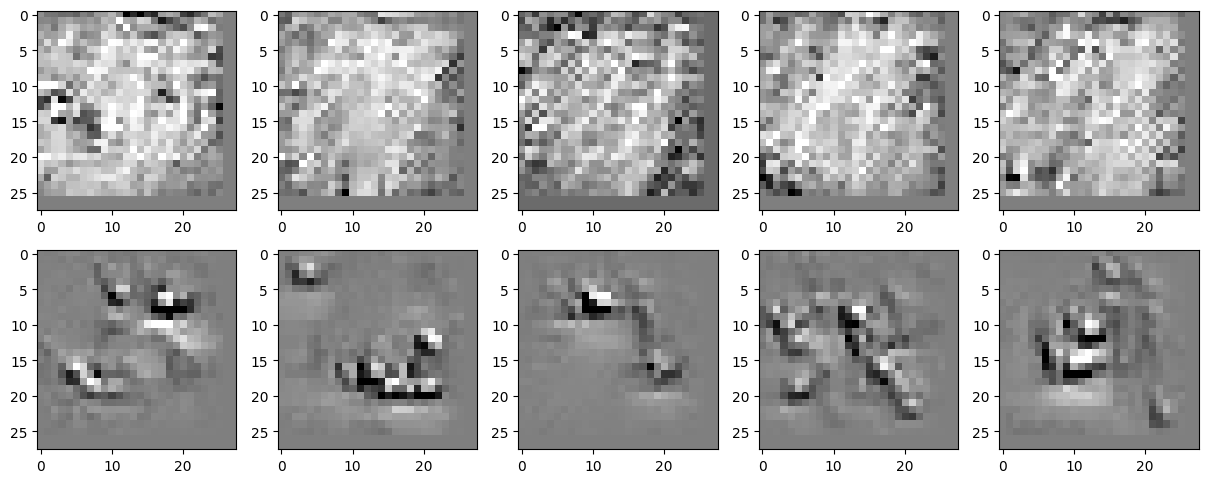

In [ ]:
# Model Inversion Attack on client2 model

# Create the attack
attack = MIFace(client2_model, max_iter=10000, threshold=1.5)
# for each 10 MNIST classes
y = np.arange(10)
# Experiment on Grey Sample
x_init_grey = np.zeros((10, 28, 28, 1)) + 0.5
# Calculate the gradient
class_gradient = client2_model.class_gradient(x_init_grey, y)
class_gradient = np.reshape(class_gradient, (10, 28*28))
class_gradient_max = np.max(class_gradient, axis=1)
print("Minimum over all maximum class gradient: %f" % (np.min(class_gradient_max)))
# Run the attack
x_infer_from_grey = attack.infer(x_init_grey, y)
# Plot the inferred images:
plt.figure(figsize=(15,15))
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.imshow( (np.reshape(x_infer_from_grey[0+i,], (28, 28))), cmap=plt.cm.gray_r)